# Bag of Visual Words

In [1]:
# Import libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import random as rd
import os

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
np.random.seed(1)

Using TensorFlow backend.


## Utils function

In [2]:
def iou(boxA, boxB):
    """
    Compute the IOU metric
    -----------------
    Parameters:
        boxA, boxB are list of corners, top left corner and bottom right corner
        in total 4 coordinates for box [x_tl, y_tl, x_br, y_br]
    Cite:
        https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    # computation of top left and bottom right coordinates
    # for the interseption rectangle
    xi_1 = max(boxA[0], boxB[0])
    yi_1 = max(boxA[1], boxB[1])
    xi_2 = min(boxA[2], boxB[2])
    yi_2 = min(boxA[3], boxB[3])
    
    
    # interseption area
    area_i = max(0, xi_2 - xi_1 + 1) * max(0, yi_2 - yi_1 + 1)
    
    # areas box A and box B
    area_A = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    area_B = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # Interseption over Union
    iou = area_i / float(area_A + area_B - area_i)
    return iou

In [3]:
def extract_name(absolute_path):
    i = 0
    for j in range(len(absolute_path)):
        char = absolute_path[j]
        if char == '/' or char == '\\':
            i = j
    name = absolute_path[i+1:-4]
    return name

In [4]:
def patch(img, box, resize=True):
    """
    It returns the corresponding patch given a bounding box and an image
    box has structure [xa, ya, xb, yb]
    (xa, ya) top left corner
    (xb, yb) bottom right corner
    """
    xa = box[0]
    ya = box[1]
    xb = box[2]
    yb = box[3]
    
    result = img[ya:yb, xa:xb]
    
    if resize:
        result = cv2.resize(result, (224,224), interpolation = cv2.INTER_LINEAR)
    return result

## Loading true bounding boxes and images

Loading ground truth bounding boxes as pandas dataframes

In [5]:
gt_boxes = []
folder = "../dataset/FINAL_DATASET/TRAINING_DATASET/LABELS_TXT"
folder +=  "/*.txt"

filenames = []

for path in glob.glob(folder):
    file = extract_name(path)
    
    # We use a pandas dataframe for each image to store all bounding boxes
    if os.path.getsize(path) > 0:
        filenames.append(file)
        df = pd.read_csv(path, sep=';', header=None).iloc[:,:-1]
        series = df.iloc[:,0]
        new_column = []
        for elem in series:
            elem = elem.split(':')
            new_column.append(int(elem[-1]))
        df.iloc[:,0] = new_column

        gt_boxes.append(df)
    
print("Number of boats with labels: {}".format(len(gt_boxes)))

Number of boats with labels: 3106


Example of bounding boxes given an image:

In [6]:
gt_boxes[0]

,0,1,2,3
0,304,598,44,132
1,436,562,2,30


Loading images

In [7]:
folder = "../dataset/FINAL_DATASET/TRAINING_DATASET/IMAGES"
X_boats = []

for name in filenames:
    file = folder + "/" + name + ".png"
    X_boats.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
    
print("Number of boats loaded: {}".format(len(X_boats)))

Number of boats loaded: 3106


## ML Dataset creation

Class 1: boats

In [8]:
# Resizing all images
# Bilinear interpolation
image_size = (224,224)
X = []

for i in range(len(X_boats)):
    img = X_boats[i]
    for j in range(gt_boxes[i].shape[0]):
        true_box = gt_boxes[i].iloc[j,:].to_list()
        X.append(patch(img, [true_box[0], true_box[2], true_box[1], true_box[3]]))

In [9]:
Y = [1 for elem in X]

In [10]:
print("Number of class 1 samples: {}".format(len(X)))
print("Number of labels: {}".format(len(Y)))

Number of class 1 samples: 5089
Number of labels: 5089


Class 0: others

In [11]:
MAX_NEGATIVES = 2

count = 0
for n in range(MAX_NEGATIVES):
    for i in range(len(X_boats)):
        img = X_boats[i]
        x = rd.randint(0, img.shape[1] - image_size[0])
        y = rd.randint(0, img.shape[0] - image_size[1])

        box = [x, y, x + image_size[0], y + image_size[1]]

        # If the bounding box chosen randomly doesn't have a IoU > 0.5
        # with any true bounding box, than we consider this a false image
        # Class 0 of no-boats
        check = True
        for j in range(gt_boxes[i].shape[0]):
            true_box = gt_boxes[i].iloc[j,:].to_list()
            if iou(box, [true_box[0], true_box[2], true_box[1], true_box[3]]) > 0.25: 
                check = False
        if check:
            X.append(patch(img, box, False))
            Y.append(0)
            count += 1

In [12]:
print("Number of class 0 samples: {}".format(count))
print()
print("Number of TOTAL samples: {}".format(len(X)))
print("Number of labels: {}".format(len(Y)))

Number of class 0 samples: 5218

Number of TOTAL samples: 10307
Number of labels: 10307


We convert everything into numpy array objects and split X and Y in training set, validation set and test set.

In [13]:
X = np.array(X)
print("X:")
print(X.shape)
print()
print("Number of samples: {}".format(X.shape[0]))
print("Image shape: ({},{})".format(X.shape[1], X.shape[2]))
print("Number of channels: {}".format(X.shape[3]))

Y = np.array(Y)
print()
print("Y:")
print(Y.shape)

X:
(10307, 224, 224, 3)

Number of samples: 10307
Image shape: (224,224)
Number of channels: 3

Y:
(10307,)


In [14]:
# Now we split the dataset into
# 1. training set
# 2. validation set
# 3. test set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=1)
print("Training set: {} and {}".format(X_train.shape, y_train.shape))
print("Validation set: {} and {}".format(X_val.shape, y_val.shape))
print("Test set: {} and {}".format(X_test.shape, y_test.shape))

Training set: (6183, 224, 224, 3) and (6183,)
Validation set: (2062, 224, 224, 3) and (2062,)
Test set: (2062, 224, 224, 3) and (2062,)


Plot some samples:

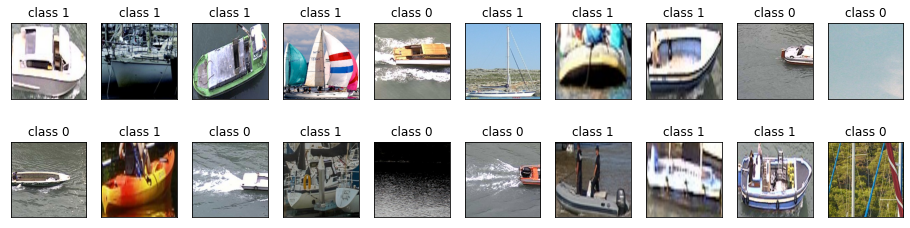

In [15]:
rows = 2
cols = 10
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(16,4))

for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(X_train[count,:,:,:])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title('class ' + str(y_train[count]))
        count += 1
plt.savefig('../report/figures/dataset_samples.png')

## CLASSIFICATION

In our case X_val will be used to craete a visual vocabulary, instead X_train is to train our chosen clissifier. For a check on final performance we will use X_test (every set with respective labels).

**Visual vocabulary**

In [16]:
# Creation of sift object
sift = cv2.xfeatures2d.SIFT_create()

In [17]:
val_keypoints = []
val_descriptors = []
discarded = []

for i in range(X_val.shape[0]):
    image = X_val[i,:,:,:]
    kps, des = sift.detectAndCompute(image, None)
    if len(kps) == 0:
        discarded.append(i)
    else:   
        val_keypoints.append(kps)
        val_descriptors.append(des)


X_val = np.delete(X_val, discarded, axis=0)
y_val = np.delete(y_val, discarded)

print("Number of samples on validation set: {}".format(X_val.shape[0]))
print("Labels: {}".format(y_val.shape[0]))

Number of samples on validation set: 2000
Labels: 2000


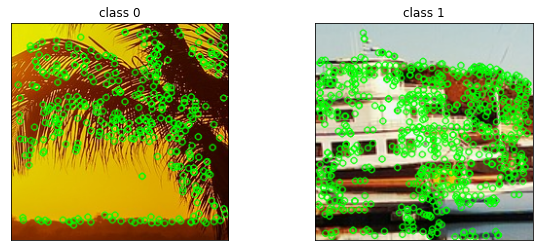

In [35]:
# We show features from some random image of class 0 and class 1 
rows = 1
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(10,4))

class1_index = rd.choice([i for i in range(y_val.shape[0]) if y_val[i] == 1])
class0_index = rd.choice([i for i in range(y_val.shape[0]) if y_val[i] == 0])


kps = val_keypoints[class0_index]
ax[0].imshow(cv2.drawKeypoints(X_val[class0_index,:,:,:], kps, None, color=(0,255,0)))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('class ' + str(y_val[class0_index]))


kps = val_keypoints[class1_index]
ax[1].imshow(cv2.drawKeypoints(X_val[class1_index,:,:,:], kps, None, color=(0,255,0)))
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('class ' + str(y_val[class1_index]))



plt.savefig('../report/figures/keypoints.png')

In [19]:
# We create a matrix with all feature decriptors
all_descriptors = np.array(val_descriptors[0])

for i in range(len(val_descriptors)):
    if val_descriptors[i].size != 0:
        all_descriptors = np.concatenate((all_descriptors, val_descriptors[i]))
        
print(all_descriptors.shape)

(579693, 128)


In [20]:
num_visual_words = 500
bowtrainer = cv2.BOWKMeansTrainer(num_visual_words)
bowtrainer.add(np.array(all_descriptors))
vocabulary = bowtrainer.cluster()

In [21]:
# Saving the vocabulary
np.savetxt("BoW_vocabulary.txt", vocabulary)

_From OpenCV documentation_:  

**BOWImgDescriptorExtractor**  
Class to compute an image descriptor using the bag of visual words. 

Such a computation consists of the following steps: 

Compute descriptors for a given image and its keypoints set. 
Find the nearest visual words from the vocabulary for each keypoint descriptor. 
Compute the bag-of-words image descriptor as is a normalized histogram of vocabulary words encountered in the image. The i-th bin of the histogram is a frequency of i-th word of the vocabulary in the given image. 

In [22]:
bow_des_extr = cv2.BOWImgDescriptorExtractor(sift, cv2.BFMatcher(cv2.NORM_L2))
bow_des_extr.setVocabulary(vocabulary)

### Training and Testing

In [23]:
# Feature descriptors for training set
train_keypoints = []
train_descriptors = []
discarded = []

for i in range(X_train.shape[0]):
    image = X_train[i,:,:,:]
    kps, des = sift.detectAndCompute(image, None)
    if len(kps) == 0:
        discarded.append(i)
    else:   
        train_keypoints.append(kps)
        train_descriptors.append(des)


X_train = np.delete(X_train, discarded, axis=0)
y_train = np.delete(y_train, discarded)

print("Number of samples on train set: {}".format(X_train.shape[0]))
print("Labels: {}".format(y_train.shape[0]))

Number of samples on train set: 6013
Labels: 6013


In [24]:
# Feature descriptors for test set
test_keypoints = []
test_descriptors = []
discarded = []

for i in range(X_test.shape[0]):
    image = X_test[i,:,:,:]
    kps, des = sift.detectAndCompute(image, None)
    if len(kps) == 0:
        discarded.append(i)
    else:   
        test_keypoints.append(kps)
        test_descriptors.append(des)


X_test = np.delete(X_test, discarded, axis=0)
y_test = np.delete(y_test, discarded)

print("Number of samples on test set: {}".format(X_test.shape[0]))
print("Labels: {}".format(y_test.shape[0]))

Number of samples on test set: 2011
Labels: 2011


Bellow we will compute the final feature vector used in all classification methods (ML methods such as SVM, Nearest Neighbor (NN), k-NN, etc..). These feature vectors are histograms of our visual words.

In [25]:
fv_train = []
fv_test = []

for i in range(X_train.shape[0]):
    fv_train.append(bow_des_extr.compute(X_train[i,:,:,:], train_keypoints[i]))
for i in range(X_test.shape[0]):
    fv_test.append(bow_des_extr.compute(X_test[i,:,:,:], test_keypoints[i]))
    
print("Number of feature vector for TRAINING SET: {}".format(len(fv_train)))
print("Number of feature vector for TEST SET: {}".format(len(fv_test)))

Number of feature vector for TRAINING SET: 6013
Number of feature vector for TEST SET: 2011


Plots of some histograms for image

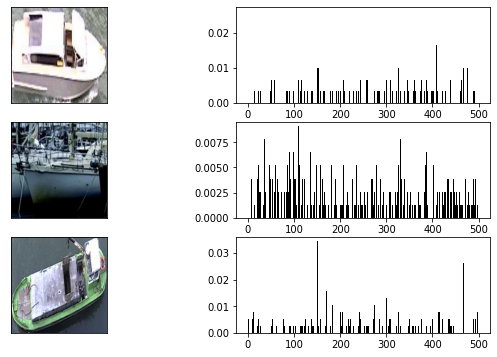

In [26]:
rows = 3
cols = 2
count = 0

fig, ax = plt.subplots(rows, cols, figsize=(10,6))

for i in range(rows):
    ax[i,0].imshow(X_train[count,:,:,:])
    ax[i,1].bar(np.arange(num_visual_words), fv_train[count].reshape(-1), color='k')
    count += 1
    
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    
plt.savefig('../report/figures/hist.png')

### Nearest-Neighbor

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
print('******** Nearest Neighbor *******')
train_data = cv2.ml.TrainData_create(np.array(fv_train).reshape(X_train.shape[0], num_visual_words), cv2.ml.ROW_SAMPLE, y_train)
nearest_neighbor = cv2.ml.KNearest_create()
nearest_neighbor.setDefaultK(1)

# Training
nearest_neighbor.train(train_data)
retval, y_pred = nearest_neighbor.predict(np.array(fv_train).reshape(X_train.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy training: {:.2f}%".format(accuracy_score(y_train, y_pred) * 100))

# Testing
retval, y_pred = nearest_neighbor.predict(np.array(fv_test).reshape(X_test.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy test: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

******** Nearest Neighbor *******
Accuracy training: 99.97%
Accuracy test: 83.19%


### K-Nearest-Neighbor

In [29]:
print('******** k-Nearest Neighbor (k=3) *******')
train_data = cv2.ml.TrainData_create(np.array(fv_train).reshape(X_train.shape[0], num_visual_words), cv2.ml.ROW_SAMPLE, y_train)
knn = cv2.ml.KNearest_create()
knn.setDefaultK(3)

# Training
knn.train(train_data)
retval, y_pred = knn.predict(np.array(fv_train).reshape(X_train.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy training: {:.2f}%".format(accuracy_score(y_train, y_pred) * 100))

# Testing
retval, y_pred = knn.predict(np.array(fv_test).reshape(X_test.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy test: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

******** k-Nearest Neighbor (k=3) *******
Accuracy training: 87.74%
Accuracy test: 82.65%


In [30]:
print('******** k-Nearest Neighbor (k=5) *******')
train_data = cv2.ml.TrainData_create(np.array(fv_train).reshape(X_train.shape[0], num_visual_words), cv2.ml.ROW_SAMPLE, y_train)
knn = cv2.ml.KNearest_create()
knn.setDefaultK(5)

# Training
knn.train(train_data)
retval, y_pred = knn.predict(np.array(fv_train).reshape(X_train.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy training: {:.2f}%".format(accuracy_score(y_train, y_pred) * 100))

# Testing
retval, y_pred = knn.predict(np.array(fv_test).reshape(X_test.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy test: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

******** k-Nearest Neighbor (k=5) *******
Accuracy training: 84.98%
Accuracy test: 82.94%


### SVM

In [31]:
print('******** SVM *******')
kernels = ['LINEAR', 'POLY', 'RBF', 'SIGMOID', 'CHI2', 'INTER']

train_data = cv2.ml.TrainData_create(np.array(fv_train).reshape(X_train.shape[0], num_visual_words), cv2.ml.ROW_SAMPLE, y_train)
svm = cv2.ml.SVM_create()
#svm.setKernel(3)
print("Kernel: {}".format(kernels[svm.getKernelType()]))

# Training
svm.train(train_data)
retval, y_pred = svm.predict(np.array(fv_train).reshape(X_train.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy training: {:.2f}%".format(accuracy_score(y_train, y_pred) * 100))

# Testing
retval, y_pred = svm.predict(np.array(fv_test).reshape(X_test.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy test: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

******** SVM *******
Kernel: RBF
Accuracy training: 89.86%
Accuracy test: 87.72%


In [32]:
print('******** SVM *******')
kernels = ['LINEAR', 'POLY', 'RBF', 'SIGMOID', 'CHI2', 'INTER']

train_data = cv2.ml.TrainData_create(np.array(fv_train).reshape(X_train.shape[0], num_visual_words), cv2.ml.ROW_SAMPLE, y_train)
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_CHI2)
print("Kernel: {}".format(kernels[svm.getKernelType()]))

# Training
svm.train(train_data)
retval, y_pred = svm.predict(np.array(fv_train).reshape(X_train.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy training: {:.2f}%".format(accuracy_score(y_train, y_pred) * 100))

# Testing
retval, y_pred = svm.predict(np.array(fv_test).reshape(X_test.shape[0], num_visual_words))
y_pred.reshape(-1)
print("Accuracy test: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

******** SVM *******
Kernel: CHI2
Accuracy training: 97.14%
Accuracy test: 89.16%


The best model so far seems to be 'SVM' with kernel CHI2

In [33]:
svm.save('svm.txt')